In [104]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Q2.1: Normalization

In [118]:
def feature_normalization(train,test):
    
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization

    """
    # TODO
    train_max = train.max(0)
    train_min = train.min(0)
    train_normalized = (train - train_min)/(train_max - train_min)
    test_normalized = (test - train_min)/(train_max - train_min)
    return train_normalized, test_normalized

## Q2.2a: The square loss function

$J=\frac{1}{2m} \cdot (X \cdot \theta - y) \cdot (X \cdot \theta - y)^T$

In [74]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)
    
    Returns:
        loss - the square loss, scalar
    """
    loss = 0 #initialize the square_loss
    #TODO
    residual = np.dot(X, theta)-y
    residual2 = residual**2
    loss = np.sum(residual2)/(2*X.shape[0])
    return loss

## Q2.2b: compute the gradient of square loss function

In [58]:
### compute the gradient of square loss function
def compute_square_loss_gradient(X, y, theta):
    """Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
    
    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    #TODO
    grad = np.zeros(X.shape[1])
    grad = np.dot(X.T, np.dot(X,theta)-y)/X.shape[0]
    return grad

In [70]:
X=np.array([[2,3,4],[1,2,1],[4,5,4]])
y=np.array([4,3,2])
theta=np.array([1,1,1])
compute_square_loss_gradient(X,y,theta)

array([18.33333333, 24.        , 21.66666667])

## 2.3 Gradient Checker

In [75]:
### Gradient Checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm.  Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4): 
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions: 
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1) 

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by: 
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error
    
    Return:
        A boolean value indicate whether the gradient is correct or not

    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    #TODO
    coor_vector = np.diag(np.ones(num_features))
    for i in range(num_features):
        print(coor_vector[i])
        diff = compute_square_loss(X, y, theta+epsilon*coor_vector[i])-compute_square_loss(X, y, theta-epsilon*coor_vector[i])
        euclidean_dist = diff/(2*epsilon)
        approx_grad[i] = euclidean_dist
    
    sum_of_square = np.sum((true_gradient - approx_grad)**2)
    eclid = np.sqrt(sum_of_square)
    if eclid <= tolerance:
        return True
    else:
        return False
    

In [87]:
grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4)

[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]


True

## 2.4 Batch Gradient Descent

In [165]:
# loading datasets
df = pd.read_csv(r'/Users/chenwangyang/Downloads/hw1-sgd/hw1-data.csv')
X = df.values[:,:-1]
y = df.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)
print(X.shape)
print("normalization")
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0],1))))  # add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0],1))))  # add bias term

def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False):
    """
    In this question you will implement batch gradient descent to
    minimize the square loss objective
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        num_iter - number of iterations to run 
        check_gradient - a boolean value indicating whether checking the gradient when updating
    Returns:
        theta_hi- store the the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features) 
                    for instance, theta in iteration 0 should be theta_hist[0], theta in ieration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1) 
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.ones(num_features) #initialize theta
    #TODO
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta_hist[0])
    for i in range(1, num_iter+1):
        grad = compute_square_loss_gradient(X, y, theta_hist[i-1])
        theta_hist[i] = theta_hist[i-1] - alpha*grad
        loss_hist[i] = compute_square_loss(X, y, theta_hist[i])
    return theta_hist, loss_hist
    
    

(200, 48)
normalization


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()


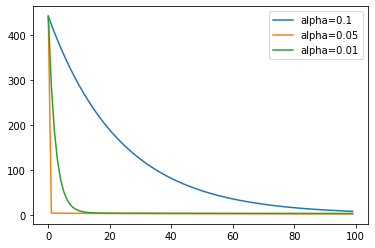

In [159]:
import matplotlib.pyplot as plt
a1, b1 = batch_grad_descent(X_train, y_train, alpha=0.5, num_iter=1000, check_gradient=False)
a2, b2 = batch_grad_descent(X_train, y_train, alpha=0.1, num_iter=1000, check_gradient=False)
a3, b3 = batch_grad_descent(X_train, y_train, alpha=0.05, num_iter=1000, check_gradient=False)
a4, b4 = batch_grad_descent(X_train, y_train, alpha=0.01, num_iter=1000, check_gradient=False)
x = list(range(100))
plt.plot(x, b2[0:100])
plt.plot(x, b3[0:100])
plt.plot(x, b4[0:100])
plt.legend(['alpha=0.1', 'alpha=0.05', 'alpha=0.01'], loc='upper right')
plt.show()

In [267]:
a1[-1][-1]

array([-0.17399919,  0.00192546,  0.10722577,  0.13974512, -0.06916799,
       -0.04989158, -0.03441772, -0.03441772,  0.0743133 ,  0.16812988,
        0.19520821,  0.03915749, -0.12613597, -0.2226354 ,  0.19329246,
        0.24887605,  0.20303474,  0.04475822, -0.01641682, -0.01641682,
       -0.01641682,  0.00915056,  0.00915056,  0.00915056,  0.01787128,
        0.01787128,  0.01787128,  0.02189118,  0.02189118,  0.02189118,
        0.02411513,  0.02411513,  0.02411513,  0.04130776,  0.04130776,
        0.04130776,  0.05223941,  0.05223941,  0.05223941,  0.0426691 ,
        0.0426691 ,  0.0426691 ,  0.03822655,  0.03822655,  0.03822655,
        0.0357577 ,  0.0357577 ,  0.0357577 , -0.22340526])

In [269]:
from scipy.optimize import minimize
w_opt = minimize(compute_square_loss(X, y, theta_hist[0]), np.ones(X.shape[1]))

NameError: name 'theta_hist' is not defined

## 2.5 Ridge Regression

In [224]:
### Compute the gradient of Regularized Batch Gradient Descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized square loss function given X, y and theta
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient
    
    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    #TODO
    grad = np.zeros(X.shape[1])
    grad = np.dot(X.T, np.dot(X, theta)-y)/X.shape[0] +2*lambda_reg*theta
    return grad

In [171]:
compute_regularized_square_loss_gradient(X, y, theta=np.ones(X.shape[1]), lambda_reg=0.1)

array([10.09643067, 11.6529978 , 12.88129932, 13.42033071, 15.00509391,
       15.37012083, 15.5450657 , 15.52373192, 15.21836042, 14.53409172,
       13.75158815, 13.06224432, 11.82000679, 10.8263714 ,  8.50582589,
        7.20927954,  4.69027643,  1.78929913, 12.90726225, 12.90726225,
       63.73631127, 12.90523907, 12.90523907, 63.72619534, 11.67629633,
       11.67629633, 57.58148164, 10.3896644 , 10.3896644 , 51.14832201,
        9.26724536,  9.26724536, 45.53622681,  0.68480704,  0.68480704,
        2.62403519,  2.17295966,  2.17295966, 10.06479832,  2.45642428,
        2.45642428, 11.48212139,  2.40671371,  2.40671371, 11.23356855,
        2.26599985,  2.26599985, 10.52999927])

In [179]:
### Batch Gradient Descent with regularization term
def regularized_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        numIter - number of iterations to run 
        
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features) 
        loss_hist - the history of regularized loss value, 1D numpy array
    """
    (num_instances, num_features) = X.shape
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #Initialize loss_hist
    #TODO
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta_hist[0]) + lambda_reg*np.dot(theta_hist[0].T,theta_hist[0])
    for i in range(1, num_iter+1):
        theta_hist[i] = theta_hist[i-1] - alpha*compute_regularized_square_loss_gradient(X, y, theta_hist[i-1], lambda_reg)
        loss_hist[i] = compute_square_loss(X, y, theta_hist[i]) + lambda_reg*np.dot(theta_hist[i].T,theta_hist[i])
    return theta_hist, loss_hist

In [180]:
# train the model with training data
loss_train = []
theta_train = []
labda = [10**(-7),10**(-5),10**(-3),0.1,1,10]
for l in labda:
    theta, loss = regularized_grad_descent(X_train, y_train, alpha=0.1, lambda_reg=l, num_iter=1000)
    index = np.argmin(loss)
    loss_train.append(loss[index])
    theta_train.append(theta[index])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


In [190]:
# fit the model with testing data
loss_test = []
for i in range(len(loss_train)):
    loss_test.append(compute_square_loss(X_test, y_test, theta_train[i])+labda[i]*np.dot(theta_train[i].T,theta_train[i]))

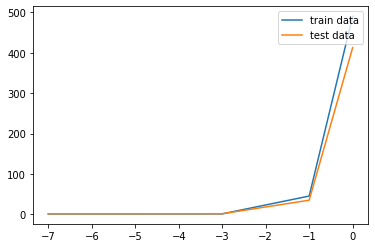

In [197]:
x = np.log10(labda)
plt.plot(x, loss_train)
plt.plot(x, loss_test)

plt.legend(['train data','test data'],loc = 'upper right')
plt.show()

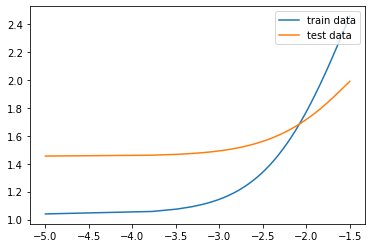

In [204]:
# zoom in
loss_train = []
theta_train = []
loss_test = []
labda = np.linspace(10**-5,10**-1.5,200)
for l in labda:
    theta, loss = regularized_grad_descent(X_train, y_train, alpha=0.1, lambda_reg=l, num_iter=1000)
    index = np.argmin(loss)
    loss_train.append(loss[index])
    theta_train.append(theta[index])

for i in range(len(loss_train)):
    loss_test.append(compute_square_loss(X_test, y_test, theta_train[i])+labda[i]*np.dot(theta_train[i].T,theta_train[i]))

x = np.log10(labda)
plt.plot(x, loss_train)
plt.plot(x, loss_test)

plt.legend(['train data','test data'],loc = 'upper right')
plt.show()

In [206]:
# Find the best theta
print("The best lambda is ")
print(labda[np.argmin(loss_test)])
theta_train[np.argmin(loss_test)]

The best lambda is 
1e-05


array([-1.57727835,  0.62982923,  1.41852151,  3.79013739, -3.12883397,
       -0.47206517, -1.00012668, -1.00012668,  1.27592076,  1.44982316,
        3.8231875 , -1.22530963, -0.69438931, -5.38323726,  1.89947522,
        3.4500238 ,  1.1868606 ,  0.69596208,  0.02134501,  0.02134501,
        0.02134501, -0.06625788, -0.06625788, -0.06625788, -0.04228965,
       -0.04228965, -0.04228965, -0.02968369, -0.02968369, -0.02968369,
       -0.02221293, -0.02221293, -0.02221293, -0.17860923, -0.17860923,
       -0.17860923, -0.012776  , -0.012776  , -0.012776  , -0.0087915 ,
       -0.0087915 , -0.0087915 , -0.00666629, -0.00666629, -0.00666629,
       -0.00540459, -0.00540459, -0.00540459, -1.18295573])

## 2.6 Stochastic Gradient Descent

In [249]:
### Stochastic Gradient Descent
def stochastic_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    In this question you will implement stochastic gradient descent with a regularization term
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float. step size in gradient descent
                NOTE: In SGD, it's not always a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every iteration is alpha.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t)
                if alpha == "1/t", alpha = 1/t
        lambda_reg - the regularization coefficient
        num_iter - number of epochs (i.e number of times) to go through the whole training set
    
    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features) 
        loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #Initialize loss_hist
    
    #TODO
    arr = np.arange(num_instances)
    t = 1
    for iteration in range(num_iter):
        np.random.shuffle(arr)
        for i in range(num_instances):
            theta_hist[iteration][i] = theta
            loss_hist[iteration][i] = compute_square_loss(X, y, theta) + lambda_reg*np.dot(theta.T,theta)
            if isinstance(alpha, float):
                alpha_f = alpha
            elif alpha == '1/sqrt(t)':
                alpha_f = 1/t**0.5
            elif alpha == '1/t':
                alpha_f = 1/t
            t=t+1
            theta = theta - alpha_f * compute_regularized_square_loss_gradient(X[arr[i],:], y[arr[i]], theta, lambda_reg)
    return theta_hist, loss_hist
                


In [250]:
# loading datasets
df = pd.read_csv(r'/Users/chenwangyang/Downloads/hw1-sgd/hw1-data.csv')
X = df.values[:,:-1]
y = df.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)
print(X.shape)
print("normalization")
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0],1))))  # add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0],1))))  # add bias term

(200, 48)
normalization


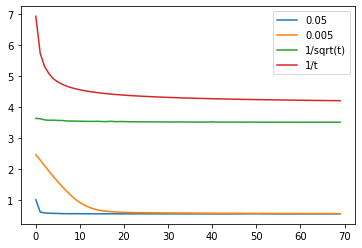

In [254]:
# plot with different step size
a1, b1 = stochastic_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=0.01, num_iter=70)
a2, b2 = stochastic_grad_descent(X_train, y_train, alpha=0.005, lambda_reg=0.01, num_iter=70)
a3, b3 = stochastic_grad_descent(X_train, y_train, alpha='1/sqrt(t)', lambda_reg=0.01, num_iter=70)
a4, b4 = stochastic_grad_descent(X_train, y_train, alpha='1/t', lambda_reg=0.01, num_iter=70)

plt.plot(range(70), np.log10(b1[:,-1]))
plt.plot(range(70), np.log10(b2[:,-1]))
plt.plot(range(70), b3[:,-1])
plt.plot(range(70), b4[:,-1])
plt.legend(['0.05','0.005','1/sqrt(t)','1/t'], loc = 'upper right')
plt.show()

In [257]:
# calculate the amount of time
import timeit
import time
def time_cal(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):    
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #Initialize loss_hist
    
    #TODO
    time_hist = np.zeros(num_iter)
    arr = np.arange(num_instances)
    t = 1
    for iteration in range(num_iter):
        np.random.shuffle(arr)
        start = time.time()
        for i in range(num_instances):
            theta_hist[iteration][i] = theta
            loss_hist[iteration][i] = compute_square_loss(X, y, theta) + lambda_reg*np.dot(theta.T,theta)
            if isinstance(alpha, float):
                alpha_f = alpha
            elif alpha == '1/sqrt(t)':
                alpha_f = 1/t**0.5
            elif alpha == '1/t':
                alpha_f = 1/t
            t=t+1
            theta = theta - alpha_f * compute_regularized_square_loss_gradient(X[arr[i],:], y[arr[i]], theta, lambda_reg)
        stop = time.time()
        time_hist[iteration] = stop - start
    return time_hist.mean()

In [258]:
for i in [0.05, 0.005, '1/sqrt(t)', '1/t']: 
    print(time_cal(X, y, alpha=i, lambda_reg=0.01, num_iter=1000))

0.004672003746032715
0.004580333232879639
0.004681364059448242
0.004649316787719727


$= E[(a-E(y))^2+(E(y))^2+2(a-E(y)(E(y)-y))\ =E(a-E(y))^2+E(E(y)-y)^2+2E(a-E(y))(E(y)-y))$


$ = E[E(f(x)-y)^2|x] \ = E[E(f(x)-E[y|x]+E[y|x]-y)^2|x] \ = E[E(f(x)-E(y|x)^2)|x + E(E(y|x)-y)^2|x] + 2E(E(f(x)-E(y|x))(E[y|x]-y)|x) \ = E(f(x)-E[y|x]^2) + E(E(y|x)-y)^2 $